# Seccion 1

In [ ]:
#Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd
from fuzzywuzzy import fuzz, process 
from metaphone import doublemetaphone
import unidecode
from jellyfish import jaro_winkler_similarity, damerau_levenshtein_distance
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


Busca en la página web de UCI o Kaggle un dataset que contenga outliers.

In [2]:
df=pd.read_csv('./insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


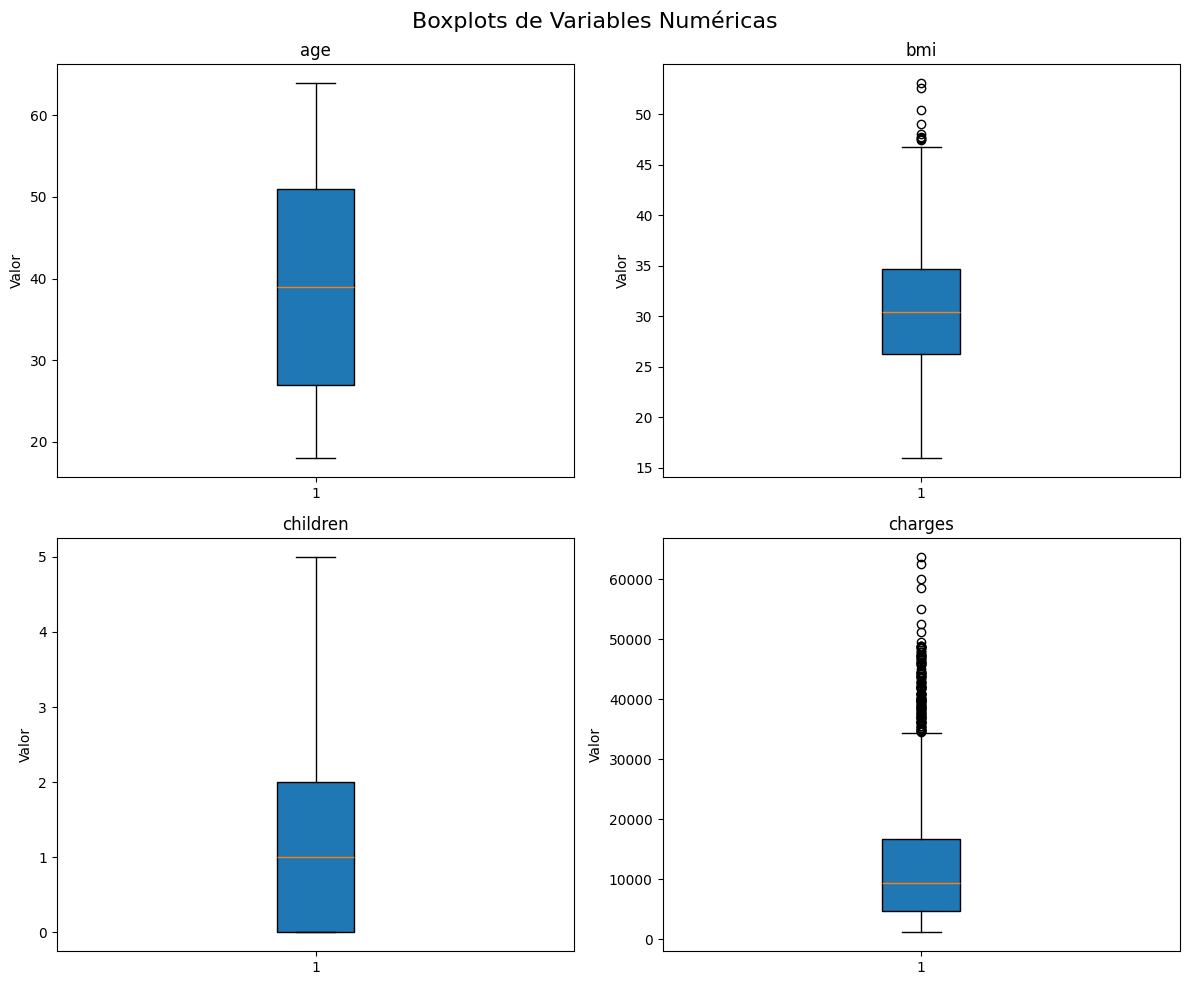

In [4]:
#vistazo general de outliers en el data set
numericas = ['age', 'bmi', 'children', 'charges']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Boxplots de Variables Numéricas', fontsize=16)

axes = axes.flatten()

for i, col in enumerate(numericas):
    axes[i].boxplot(df[col], vert=True, patch_artist=True)  
    axes[i].set_title(col)
    axes[i].set_ylabel('Valor')

plt.tight_layout()
plt.show()



### a) Genera el reporte automático que se vio en clase para explicar el dataset.

In [ ]:
# Generación de un reporte automático de perfilado de datos
profile = ProfileReport(df, title='Reporte para el costo médico personal')
profile.to_file("Reporte de datos.html")
print("\nReporte de perfilado generado:Reporte de datos.html")

ProfileReport es una clase de la biblioteca ydata-profiling la cual genera un informe detallado y automatizado del data frame que le pasamos como parámetro y se guarda como un archivo HTML interactivo

### b) Menciona aspectos destacados del dataset mediante el reporte de gráficas del punto anterior.

Se pueden destacar ciertas cosas a través de la información que el reporte nos roporciona.

Hay mas números de beneficiarios principales que se encuentran entre los 18 y 19 años en compración a las demas edades (casi el doble en comparación).

El género para los beneficiarios es equitativo y el índice de masa corporal sigue una distribución normal aunque existen ciertos valores atípicos.

La mayoria de los registros tienden a tener menos hijos y de igual manera no tienden a ser fumadores.

Las ubicaciones en las cuales se les da el servicio a los beneficiarios estan distribuidas de manera equitativa entre los cuatro valores/zonas categóricas.

Los cargos para la mayoria de los registros estan en lo mínimo cerca de 1121.8739

Las correlaciones mas fuertes se enuentra entre los cargos y el ser fumador al igual que el cargo y la edad.

De igual manera los registros se enuentran completos en su totalidad

### c) Utilizar 3 algoritmos diferentes para identificar outliers, al menos dos de ellos deben ser métodos multidimensionales, incluyendo DBSCAN.

In [5]:
df_numeric = df[numericas] #Seleccionar variables numéricas que es donde hay sentido los outliers

#Estandarización de los datos numéricos, Preprocesamiento
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(df_scaled, columns=numericas)

In [6]:
## DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)
df['outlier_dbscan'] = dbscan.fit_predict(df_scaled) == -1

## Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['outlier_iso'] = iso_forest.fit_predict(df_scaled) == -1

## Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df['outlier_lof'] = lof.fit_predict(df_scaled) == -1


In [7]:
df['outlier_consensus'] = (df['outlier_dbscan'].astype(int) + 
                          df['outlier_iso'].astype(int) + 
                          df['outlier_lof'].astype(int)) >= 3

# 5. Resultados
print("Resumen de outliers detectados:")
print(f"- DBSCAN: {df['outlier_dbscan'].sum()}")
print(f"- Isolation Forest: {df['outlier_iso'].sum()}")
print(f"- Local Outlier Factor: {df['outlier_lof'].sum()}")
print(f"\nOutliers de consenso (detectados por ≥2 métodos): {df['outlier_consensus'].sum()}")

Resumen de outliers detectados:
- DBSCAN: 65
- Isolation Forest: 67
- Local Outlier Factor: 67

Outliers de consenso (detectados por ≥2 métodos): 15


Para cada algoritmo

- Explicar cómo funciona.

Funcionamiento de DBSCAN:  DBSCAN agrupa puntos que están cercanos en un espacio multidimensional (concepto de densidad), considerando outliers aquellos puntos que no pertenecen a ningún grupo. El algoritmo comienza con un punto aleatorio no visitado y toma en cuentas dos parámetros para clasificarlo como outlier o no. Si hay al menos min_samples puntos en el radio definido como eps, forma un cluster. Los puntos que no cumplen este criterio son marcados como outliers (etiqueta -1 en el data frame)

Funcionamiento de  Isolation Forest: Algoritmo especializado en detección de anomalías con datos multidimensionales.Este algoritmo funciona con el consepto de aislamiento ya que en teoria un registro atípico se encuentra aislado del grupo de datos comunes. Se crean múltiples árboles de aislamiento (por defecto 100,parametro que se puede modificar).En cada árbol, se seleccionan atributos y puntos de división al azar en los cuales en teoria los outliers necesitan menos divisiones para ser aislados. la puntuación de anomalía se basa en la profundidad promedio necesaria para aislar un punto, criterio para detectar losoutliers. Se marca como -1 en nuestro data frame si se consideran anómalos.

El último algoritmo es el Local Outlier Factor (LOF). Es un algoritmo de detección de anomalías basado en la densidad local de los datos. Es especialmente útil para encontrar outliers en distribuciones irregulares y clusters de diferentes densidades. El funcionamiento se encarga de medir que tan aislado está un punto en comparación con sus vecinos calculando su densidad individual.
Para cada punto se calcula sus vecinos mas cercanos y despues la distancia alcanzable. Por ultimo se calcula la densidad local para el calculo del LOF score que será comparado con el de sus vecinos.


- Mencionar cuántos outliers identificó el algoritmo

DBSCAN con parámetros de radio=0.8 y número minimo mas cercano=5 se encontraron 65 outliers

Isolation Forest con un valor del 5% de valores anómalos esperados se encontraron 67

LOF con un valor de 20 vecinos para la dencisad local y un 5% de outliers esperados se encontraron 67

- Visualizar registros que hayan sido identificados como outliers. (Si son muchos, buscar alguna manera de agruparlos y mostrar conteos)



In [27]:

outliers_any = df[df['outlier_dbscan'] | df['outlier_iso'] | df['outlier_lof']].copy()

outliers_any['detected_by'] = outliers_any.apply(
    lambda row: ', '.join([
        'DBSCAN' if row['outlier_dbscan'] else '',
        'IsolationForest' if row['outlier_iso'] else '',
        'LOF' if row['outlier_lof'] else ''
    ]).replace(', ,', '').strip(', '),
    axis=1
)
 

print("\nConteo por método de detección:")
print(outliers_any['detected_by'].value_counts())

outliers_any.head(137)



Conteo por método de detección:
detected_by
LOF                             43
IsolationForest                 26
DBSCAN, IsolationForest         23
DBSCAN                          21
DBSCAN, IsolationForest, LOF    15
DBSCAN LOF                       6
IsolationForest, LOF             3
Name: count, dtype: int64


,age,sex,bmi,children,smoker,region,charges,outlier_dbscan,outlier_iso,outlier_lof,outlier_consensus,detected_by
1,18,male,33.770,1,no,southeast,1725.55230,False,False,True,False,LOF
32,19,female,28.600,5,no,southwest,4687.79700,True,True,False,False,"DBSCAN, IsolationForest"
34,28,male,36.400,1,yes,southwest,51194.55914,True,True,False,False,"DBSCAN, IsolationForest"
39,60,male,39.900,0,yes,southwest,48173.36100,False,True,False,False,IsolationForest
45,55,male,37.300,0,no,southwest,20630.28351,False,False,True,False,LOF
...,...,...,...,...,...,...,...,...,...,...,...,...
1300,45,male,30.360,0,yes,southeast,62592.87309,True,True,True,True,"DBSCAN, IsolationForest, LOF"
1301,62,male,30.875,3,yes,northwest,46718.16325,True,True,False,False,"DBSCAN, IsolationForest"
1317,18,male,53.130,0,no,southeast,1163.46270,True,True,True,True,"DBSCAN, IsolationForest, LOF"
1318,35,male,39.710,4,no,northeast,19496.71917,True,True,True,True,"DBSCAN, IsolationForest, LOF"


In [28]:
outliers_any.shape

(137, 12)

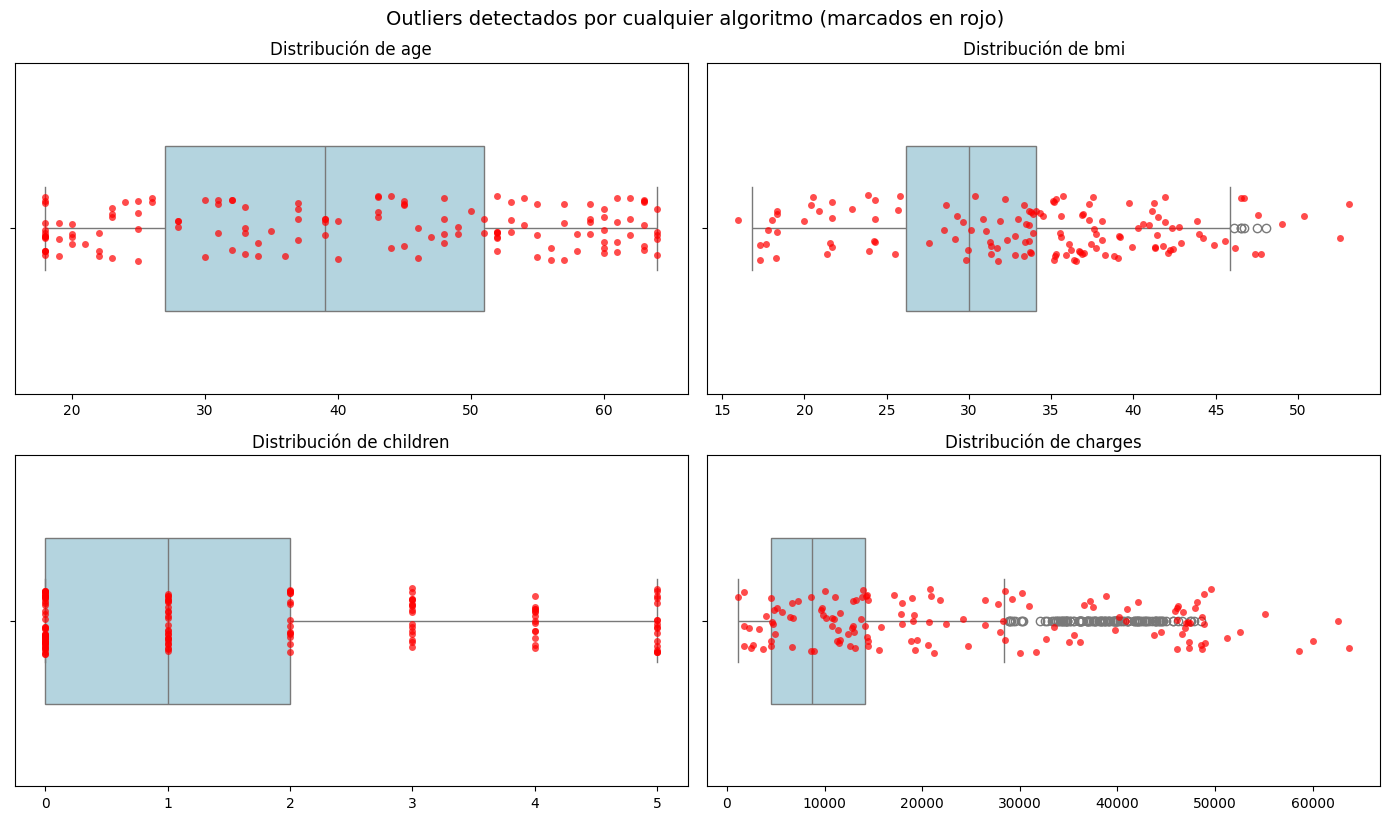

In [29]:

outliers_any = df[df['outlier_dbscan'] | df['outlier_iso'] | df['outlier_lof']]
normales = df[~(df['outlier_dbscan'] | df['outlier_iso'] | df['outlier_lof'])]


plt.figure(figsize=(14, 8))

for i, col in enumerate(numericas, 1):
    plt.subplot(2, 2, i)
    
    sns.boxplot(x=normales[col], color='lightblue', width=0.5)
    
    sns.stripplot(x=outliers_any[col], color='red', alpha=0.7, jitter=True, size=5)
    
    plt.title(f'Distribución de {col}', fontsize=12)
    plt.xlabel('')

plt.tight_layout()
plt.suptitle('Outliers detectados por cualquier algoritmo (marcados en rojo)', y=1.02, fontsize=14)
plt.show()


- ¿Exactamente los mismos registros fueron identificados como outliers por cada uno de los tres algoritmos? Justifica tu respuesta

In [30]:
outliers_summary = df[df['outlier_consensus']].copy()

outliers_summary['detected_by'] = ''
for idx, row in outliers_summary.iterrows():
    methods = []
    if row['outlier_dbscan']: methods.append('DBSCAN')
    if row['outlier_iso']: methods.append('IsolationForest')
    if row['outlier_lof']: methods.append('LOF')
    outliers_summary.at[idx, 'detected_by'] = ', '.join(methods)


print("\nResumen de outliers consensuados:")
print(outliers_summary[numericas + ['detected_by']].sort_values('charges', ascending=False))



Resumen de outliers consensuados:
      age     bmi  children      charges                   detected_by
543    54  47.410         0  63770.42801  DBSCAN, IsolationForest, LOF
1300   45  30.360         0  62592.87309  DBSCAN, IsolationForest, LOF
577    31  38.095         1  58571.07448  DBSCAN, IsolationForest, LOF
819    33  35.530         0  55135.40209  DBSCAN, IsolationForest, LOF
549    43  46.200         0  45863.20500  DBSCAN, IsolationForest, LOF
1047   22  52.580         1  44501.39820  DBSCAN, IsolationForest, LOF
292    25  45.540         2  42112.23560  DBSCAN, IsolationForest, LOF
128    32  17.765         2  32734.18630  DBSCAN, IsolationForest, LOF
1318   35  39.710         4  19496.71917  DBSCAN, IsolationForest, LOF
1085   39  18.300         5  19023.26000  DBSCAN, IsolationForest, LOF
438    52  46.750         5  12592.53450  DBSCAN, IsolationForest, LOF
640    33  42.400         5   6666.24300  DBSCAN, IsolationForest, LOF
166    20  37.000         5   4830.63000  

In [31]:
outliers_summary.shape

(15, 12)

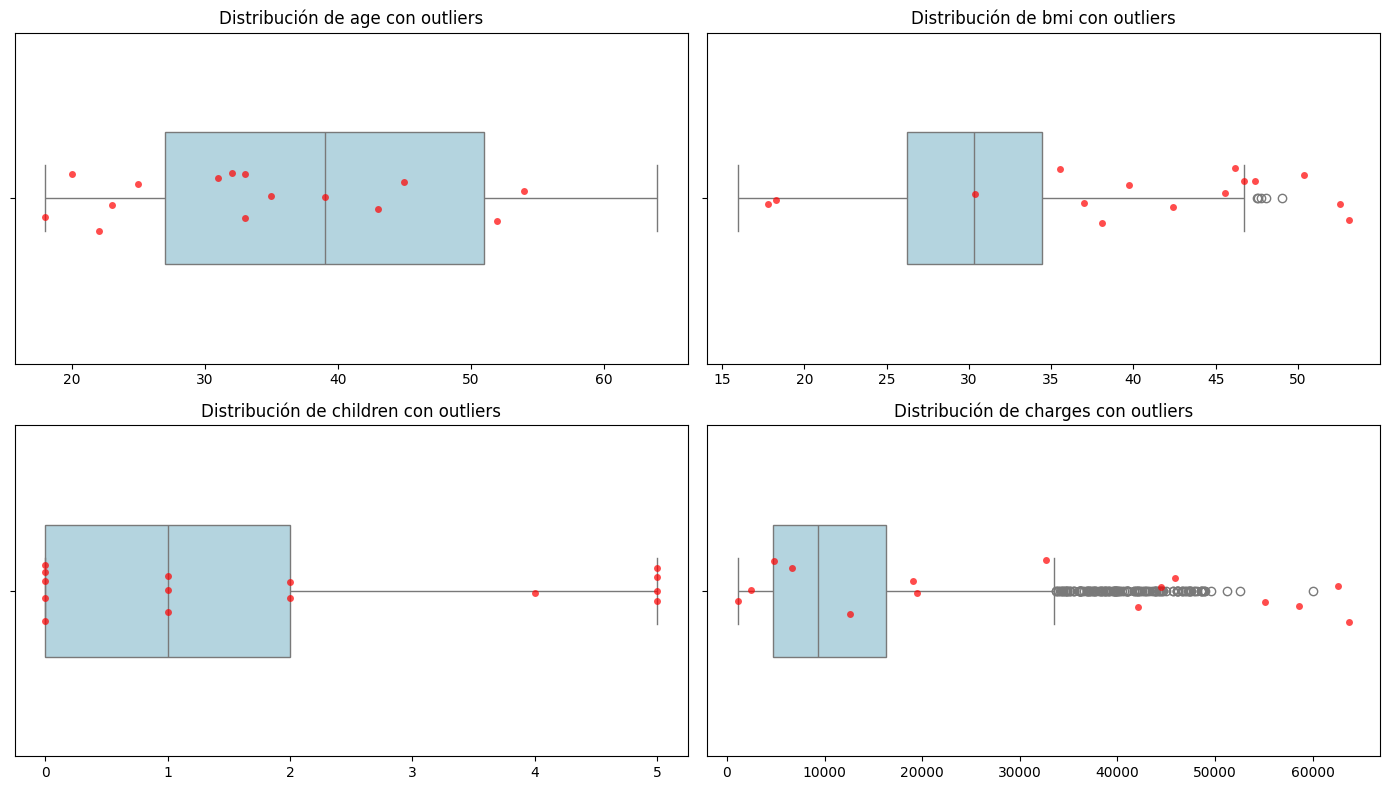

In [32]:
outliers = df[df['outlier_consensus']]
normales = df[~df['outlier_consensus']]

# 5. Boxplots individuales con outliers marcados
plt.figure(figsize=(14, 8))
for i, col in enumerate(numericas):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=normales[col], color='lightblue', width=0.4)
    sns.stripplot(x=outliers[col], color='red', alpha=0.7, jitter=True)
    plt.title(f'Distribución de {col} con outliers')
    plt.xlabel('')

plt.tight_layout()
plt.show()

In [33]:
outliers_any.shape

(137, 11)

Cada método de detección de outliers funciona bajo un principio matemático distinto, lo que explica por qué no todos coinciden en identificar los mismos valores atípicos:

DBSCAN se basa en densidad, marcando como outliers puntos aislados en regiones poco densas.

LOF (Local Outlier Factor) compara la densidad local de un punto con la de sus vecinos, detectando anomalías en zonas de densidad irregular.

Isolation Forest aisla puntos atípicos mediante divisiones aleatorias, siendo eficaz para outliers globales en distribuciones no uniformes.

Como cada método prioriza diferentes características (densidad, proximidad o separabilidad), es normal que algunos outliers solo sean detectados por uno o dos de ellos, dependiendo de su naturaleza y contexto en los datos.

# Seccion 2

In [8]:
numericas = ['age', 'bmi', 'children', 'charges']
df_numeric = df[numericas] #Seleccionar variables numéricas que es donde hay sentido los outliers

#Estandarización de los datos numéricos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(df_scaled, columns=numericas)
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['outlier_iso'] = iso_forest.fit_predict(df_scaled) == -1

Metemos el dato que queramos buscar del arbol

In [9]:
resultado_iso = df.loc[df['outlier_iso'], ['bmi']]
busqueda = resultado_iso[resultado_iso['bmi'] == 28.6]
busqueda

,bmi
32,28.6
